# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Short-study-of-the-Lempel-Ziv-complexity" data-toc-modified-id="Short-study-of-the-Lempel-Ziv-complexity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Short study of the Lempel-Ziv complexity</a></div><div class="lev2 toc-item"><a href="#Short-definition" data-toc-modified-id="Short-definition-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Short definition</a></div><div class="lev2 toc-item"><a href="#Python-implementation" data-toc-modified-id="Python-implementation-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Python implementation</a></div><div class="lev2 toc-item"><a href="#Tests-(1/2)" data-toc-modified-id="Tests-(1/2)-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Tests (1/2)</a></div><div class="lev2 toc-item"><a href="#Cython-implementation" data-toc-modified-id="Cython-implementation-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Cython implementation</a></div><div class="lev2 toc-item"><a href="#Numba-implementation" data-toc-modified-id="Numba-implementation-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Numba implementation</a></div><div class="lev2 toc-item"><a href="#Tests-(2/2)" data-toc-modified-id="Tests-(2/2)-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Tests (2/2)</a></div><div class="lev2 toc-item"><a href="#Benchmarks" data-toc-modified-id="Benchmarks-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Benchmarks</a></div><div class="lev2 toc-item"><a href="#Complexity-?" data-toc-modified-id="Complexity-?-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Complexity ?</a></div><div class="lev2 toc-item"><a href="#Conclusion" data-toc-modified-id="Conclusion-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Conclusion</a></div>

# Short study of the Lempel-Ziv complexity

In this short [Jupyter notebook](https://www.Jupyter.org/) aims at defining and explaining the [Lempel-Ziv complexity](https://en.wikipedia.org/wiki/Lempel-Ziv_complexity).

[I](http://perso.crans.org/besson/) will give examples, and benchmarks of different implementations.

- **Reference:** Abraham Lempel and Jacob Ziv, *« On the Complexity of Finite Sequences »*, IEEE Trans. on Information Theory, January 1976, p. 75–81, vol. 22, n°1.

----
## Short definition
The Lempel-Ziv complexity is defined as the number of different substrings encountered as the stream is viewed from begining to the end.

As an example:

```python
>>> s = '1001111011000010'
>>> lempel_ziv_complexity(s)  # 1 / 0 / 01 / 1110 / 1100 / 0010
6
```

Marking in the different substrings, this sequence $s$ has complexity $\mathrm{Lempel}$-$\mathrm{Ziv}(s) = 6$ because $s = 1001111011000010 = 1 / 0 / 01 / 1110 / 1100 / 0010$.

- See the page https://en.wikipedia.org/wiki/Lempel-Ziv_complexity for more details.

Other examples:

```python
>>> lempel_ziv_complexity('1010101010101010')  # 1 / 0 / 10
3
>>> lempel_ziv_complexity('1001111011000010000010')  # 1 / 0 / 01 / 1110 / 1100 / 0010 / 000 / 010
7
>>> lempel_ziv_complexity('100111101100001000001010')  # 1 / 0 / 01 / 1110 / 1100 / 0010 / 000 / 010 / 10
8
```

----
## Python implementation

In [1]:
def lempel_ziv_complexity(binary_sequence):
    """Lempel-Ziv complexity for a binary sequence, in simple Python code."""
    u, v, w = 0, 1, 1
    v_max = 1
    length = len(binary_sequence)
    complexity = 1
    while True:
        if binary_sequence[u + v - 1] == binary_sequence[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            if v > v_max:
                v_max = v
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w > length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity

----
## Tests (1/2)

In [2]:
s = '1001111011000010'
lempel_ziv_complexity(s)  # 1 / 0 / 01 / 1110 / 1100 / 0010

6

In [3]:
%timeit lempel_ziv_complexity(s)

7.03 µs ± 457 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [4]:
lempel_ziv_complexity('1010101010101010')  # 1 / 0 / 10

3

In [5]:
lempel_ziv_complexity('1001111011000010000010')  # 1 / 0 / 01 / 1110

7

In [6]:
lempel_ziv_complexity('100111101100001000001010')  # 1 / 0 / 01 / 1110 / 1100 / 0010 / 000 / 010 / 10

8

In [7]:
%timeit lempel_ziv_complexity('100111101100001000001010')

19.4 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We can start to see that the time complexity of this function seems to grow exponentially as the complexity grows.

----
## Cython implementation
As [this blog post](https://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/) explains it, we can easily try to use [Cython](http://Cython.org/) in a notebook cell.

In [8]:
%load_ext cython

In [9]:
%%cython
from __future__ import division
import cython

ctypedef unsigned int DTYPE_t

@cython.boundscheck(False) # turn off bounds-checking for entire function, quicker but less safe
def lempel_ziv_complexity_cython(str binary_sequence):
    """Lempel-Ziv complexity for a binary sequence, in simple Cython code (C extension)."""
    cdef DTYPE_t u = 0
    cdef DTYPE_t v = 1
    cdef DTYPE_t w = 1
    cdef DTYPE_t v_max = 1
    cdef DTYPE_t length = len(binary_sequence)
    cdef DTYPE_t complexity = 1
    # that was the only needed part, typing statically all the variables
    while True:
        if binary_sequence[u + v - 1] == binary_sequence[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            if v > v_max:
                v_max = v
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w > length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity

Let try it!

In [10]:
s = '1001111011000010'
lempel_ziv_complexity_cython(s)  # 1 / 0 / 01 / 1110 / 1100 / 0010

6

In [11]:
%timeit lempel_ziv_complexity_cython(s)

130 ns ± 8.72 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [12]:
lempel_ziv_complexity_cython('1010101010101010')  # 1 / 0 / 10

3

In [13]:
lempel_ziv_complexity_cython('1001111011000010000010')  # 1 / 0 / 01 / 1110

7

In [14]:
lempel_ziv_complexity_cython('100111101100001000001010')  # 1 / 0 / 01 / 1110 / 1100 / 0010 / 000 / 010 / 10

8

In [15]:
%timeit lempel_ziv_complexity_cython('100111101100001000001010')

259 ns ± 13.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


> $\implies$ Yay! It seems faster indeed!

----
## Numba implementation
As [this blog post](https://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/) explains it, we can also try to use [Numba](http://Numba.PyData.org/) in a notebook cell.

In [87]:
from numba import jit

In [94]:
@jit("int32(boolean[:])")
def lempel_ziv_complexity_numba_x(binary_sequence):
    """Lempel-Ziv complexity for a binary sequence, in Python code using numba.jit() for automatic speedup (hopefully)."""
    u, v, w = 0, 1, 1
    v_max = 1
    length = len(binary_sequence)
    complexity = 1
    while True:
        if binary_sequence[u + v - 1] == binary_sequence[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            if v > v_max:
                v_max = v
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w > length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity

def str_to_numpy(s):
    """str to np.array of bool"""
    return np.array([int(i) for i in s], dtype=np.bool)

def lempel_ziv_complexity_numba(s):
    return lempel_ziv_complexity_numba_x(str_to_numpy(s))

Let try it!

In [95]:
str_to_numpy(s)

array([ True, False, False,  True,  True,  True,  True, False,  True,
        True, False, False, False, False,  True, False], dtype=bool)

In [96]:
s = '1001111011000010'
lempel_ziv_complexity_numba(s)  # 1 / 0 / 01 / 1110 / 1100 / 0010

6

In [97]:
%timeit lempel_ziv_complexity_numba(s)

6.16 µs ± 228 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [98]:
lempel_ziv_complexity_numba('1010101010101010')  # 1 / 0 / 10

3

In [99]:
lempel_ziv_complexity_numba('1001111011000010000010')  # 1 / 0 / 01 / 1110

7

In [100]:
lempel_ziv_complexity_numba('100111101100001000001010')  # 1 / 0 / 01 / 1110 / 1100 / 0010 / 000 / 010 / 10

8

In [101]:
%timeit lempel_ziv_complexity_numba('100111101100001000001010')

9.35 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


> $\implies$ Well... It doesn't seem that much faster from the naive Python code.
> We specified the signature when calling [`@numba.jit`](http://numba.pydata.org/numba-doc/latest/user/jit.html), and used the more appropriate data structure (string is probably the smaller, numpy array are probably faster).
> But even these tricks didn't help that much.

> I tested, and without specifying the signature, the fastest approach is using string, compared to using lists or numpy arrays.
> Note that the [`@jit`](http://numba.pydata.org/numba-doc/latest/user/jit.html)-powered function is compiled at runtime when first being called, so the signature used for the *first* call is determining the signature used by the compile function

----
## Tests (2/2)

To test more robustly, let us generate some (uniformly) random binary sequences.

In [57]:
from numpy.random import binomial

def bernoulli(p, size=1):
    """One or more samples from a Bernoulli of probability p."""
    return binomial(1, p, size)

In [25]:
bernoulli(0.5, 20)

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

That's probably not optimal, but we can generate a string with:

In [26]:
''.join(str(i) for i in bernoulli(0.5, 20))

'10011100011111111011'

In [58]:
def random_binary_sequence(n, p=0.5):
    """Uniform random binary sequence of size n, with rate of 0/1 being p."""
    return ''.join(str(i) for i in bernoulli(p, n))

In [60]:
random_binary_sequence(50)
random_binary_sequence(50, p=0.1)
random_binary_sequence(50, p=0.25)
random_binary_sequence(50, p=0.5)
random_binary_sequence(50, p=0.75)
random_binary_sequence(50, p=0.9)

'11100011000111010111000110001110001110010010010010'

'00000100100000100000000000000000000100000000000000'

'00000010000010011100111010010000000000000010100010'

'11000111100001111001100000101011011011011010110110'

'11111001110101111111111101111111010111111111110111'

'11111111111111101111101111110111111001111110111111'

And so, this function can test to check that the three implementations (naive, Cython-powered, Numba-powered) always give the same result.

In [29]:
def tests_3_functions(n, p=0.5, debug=True):
    s = random_binary_sequence(n, p=p)
    c1 = lempel_ziv_complexity(s)
    if debug:
        print("Sequence s = {} ==> complexity C = {}".format(s, c1))
    c2 = lempel_ziv_complexity_cython(s)
    c3 = lempel_ziv_complexity_numba(s)
    assert c1 == c2 == c3, "Error: the sequence {} gave different values of the Lempel-Ziv complexity from 3 functions ({}, {}, {})...".format(s, c1, c2, c3)
    return c1

In [30]:
tests_3_functions(5)

Sequence s = 11010 ==> complexity C = 3


3

In [31]:
tests_3_functions(20)

Sequence s = 00011000000010010111 ==> complexity C = 6


6

In [32]:
tests_3_functions(50)

Sequence s = 00111111110000010000100011000010001100110001001101 ==> complexity C = 8


8

In [33]:
tests_3_functions(500)

Sequence s = 01011110110110010010101101110000101110100011011101100101001000001100111000011000101000000010010010010100101101101010111010001100011000100111111101101111000010001111001110010000001100011011111001001011101110001000111101100110100111011010101000010100011000010001101101000101111101001011111001100111001010100010010001111000101100110000100000010100111111000110110011110101000100110101000011001010111010101111101100111010101011110001100001111111000100100000001000100100101011010111011001101110110111111110 ==> complexity C = 60


60

In [34]:
tests_3_functions(5000)

Sequence s = 000011000001100001101000111111110101111100000101101001111110000001110110110000010111011011010111001011100100010100000110111101000010110010110001011000010000001101001100111111000101110001010000111000100101000111100111100111010111011100111100011101101001001111100100101100101001001001010010101101001111110000100111101010111100010100100001101010000001110010101010001010011010001111000011001011110100100010111111111100011110011000110100111010110011111101100111011000110010000010001101010010100000001010111111010101101111100000000010001110000000111101010011101010111111000001010111110001000000001101100110110111110011111010001100010111110110100111001001100100010110110010011001110000011001111010110000101000101111000100001110011110011000010100010100101001101011110010100110101100011000011000111100111011010001100000100100101111101010110000001011101100111001101100111111110100110011010111010100011100010000010000000011110100000000100001010110011110011011101001100001001100000100100111101110010

420

----
## Benchmarks

On two example of strings (binary sequences), we can compare our three implementation.

In [102]:
%timeit lempel_ziv_complexity('100111101100001000001010')
%timeit lempel_ziv_complexity_cython('100111101100001000001010')
%timeit lempel_ziv_complexity_numba('100111101100001000001010')

16.7 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
249 ns ± 6.71 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
7.98 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [103]:
%timeit lempel_ziv_complexity('10011110110000100000101000100100101010010111111011001111111110101001010110101010')
%timeit lempel_ziv_complexity_cython('10011110110000100000101000100100101010010111111011001111111110101001010110101010')
%timeit lempel_ziv_complexity_numba('10011110110000100000101000100100101010010111111011001111111110101001010110101010')

139 µs ± 4.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.94 µs ± 83.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
22 µs ± 364 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let check the time used by all the three functions, for longer and longer sequences:

In [104]:
%timeit tests_3_functions(10, debug=False)
%timeit tests_3_functions(20, debug=False)
%timeit tests_3_functions(40, debug=False)
%timeit tests_3_functions(80, debug=False)
%timeit tests_3_functions(160, debug=False)
%timeit tests_3_functions(320, debug=False)

28.2 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
52.3 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
108 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
359 µs ± 91.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
862 µs ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.16 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [105]:
def test_cython(n):
    s = random_binary_sequence(n)
    c = lempel_ziv_complexity_cython(s)
    return c

In [39]:
%timeit test_cython(10)
%timeit test_cython(20)
%timeit test_cython(40)
%timeit test_cython(80)
%timeit test_cython(160)
%timeit test_cython(320)

17.1 µs ± 490 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
28.8 µs ± 959 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
62.4 µs ± 6.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
125 µs ± 7.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
216 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
459 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%timeit test_cython(640)
%timeit test_cython(1280)
%timeit test_cython(2560)
%timeit test_cython(5120)

1.18 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.38 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.93 ms ± 71.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.1 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit test_cython(10240)
%timeit test_cython(20480)

52.1 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
178 ms ± 6.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


----
## Complexity ?
$\implies$ The function `lempel_ziv_complexity_cython` seems to be indeed (almost) linear in $n$, the length of the binary sequence $S$.

But let check more precisely, as it could also have a complexity of $\mathcal{O}(n \log n)$.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context="notebook", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.4)

It's durty, but let us capture manually the times given by the experiments above.

In [43]:
x = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480]
y = [18, 30, 55, 107, 205, 471, 977, 2270, 5970, 17300, 56600, 185000]

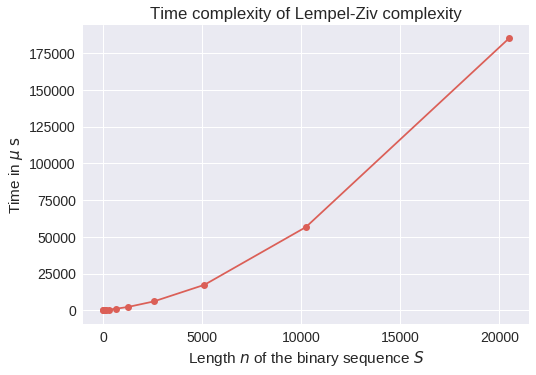

In [44]:
plt.figure()
plt.plot(x, y, 'o-')
plt.xlabel("Length $n$ of the binary sequence $S$")
plt.ylabel(r"Time in $\mu\;\mathrm{s}$")
plt.title("Time complexity of Lempel-Ziv complexity")
plt.show()

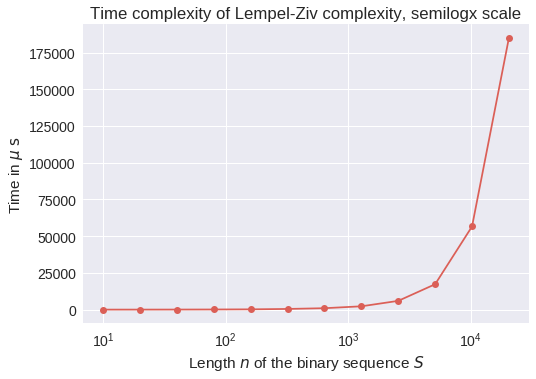

In [45]:
plt.figure()
plt.semilogx(x, y, 'o-')
plt.xlabel("Length $n$ of the binary sequence $S$")
plt.ylabel(r"Time in $\mu\;\mathrm{s}$")
plt.title("Time complexity of Lempel-Ziv complexity, semilogx scale")
plt.show()

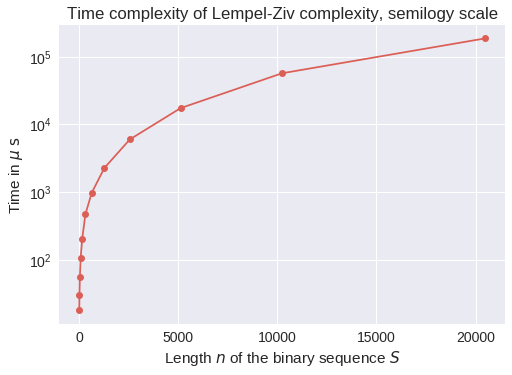

In [46]:
plt.figure()
plt.semilogy(x, y, 'o-')
plt.xlabel("Length $n$ of the binary sequence $S$")
plt.ylabel(r"Time in $\mu\;\mathrm{s}$")
plt.title("Time complexity of Lempel-Ziv complexity, semilogy scale")
plt.show()

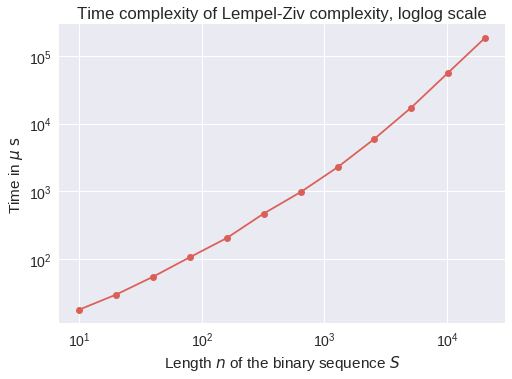

In [47]:
plt.figure()
plt.loglog(x, y, 'o-')
plt.xlabel("Length $n$ of the binary sequence $S$")
plt.ylabel(r"Time in $\mu\;\mathrm{s}$")
plt.title("Time complexity of Lempel-Ziv complexity, loglog scale")
plt.show()

It is linear in $\log\log$ scale, so indeed the algorithm seems to have a linear complexity.

To sum-up, for a sequence $S$ of length $n$, it takes $\mathcal{O}(n)$ basic operations to compute its Lempel-Ziv complexity $\mathrm{Lempel}-\mathrm{Ziv}(S)$.

----
## Conclusion

- The Lempel-Ziv complexity is not too hard to implement, and it indeed represents a certain complexity of a binary sequence, capturing the regularity and reproducibility of the sequence.

- Using the [Cython](http://Cython.org/) was quite useful to have a $\simeq \times 100$ speed up on our manual naive implementation !

- The algorithm is not easy to analyze, we have a trivial $\mathcal{O}(n^2)$ bound but experiments showed it is more likely to be $\mathcal{O}(n \log n)$ in the worst case, and $\mathcal{O}(n)$ in practice for "not too complicated sequences" (or in average, for random sequences).

----
> Thanks for reading!

> See [this repo on GitHub](https://github.com/Naereen/notebooks/) for more notebooks, or [on nbviewer.jupyter.org](https://nbviewer.jupyter.org/github/Naereen/notebooks/).

> That's it for this demo! See you, folks!